In [1]:
import typing
import numpy as np
from spdm.view import sp_view

from fytok.utils.logger import logger
from fytok.modules.equilibrium import Equilibrium
from fytok.modules.core_transport import CoreTransport
from fytok.modules.core_profiles import CoreProfiles

2024-07-22 19:18:25,729 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


## Equlibrium

In [2]:
eq = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-22 19:18:25,972 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-22 19:18:25,975 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


2024-07-22 19:18:27,932 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib


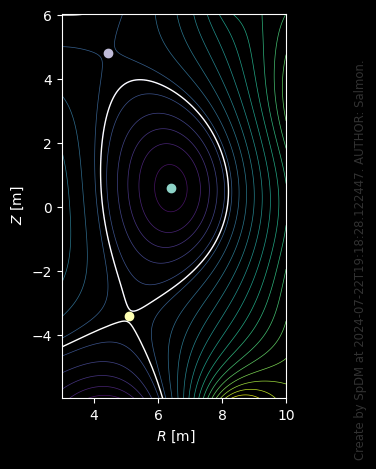

In [4]:
fig=sp_view.display(eq)

## CoreProfiles

In [3]:
rho_tor_norm = np.linspace(0.01, 0.95, 128)
core_profiles = CoreProfiles(
    vacuum_toroidal_field={"r0": 5.2, "b0": 2.5},
    profiles_1d={
        "grid": eq.profiles_1d.grid.remesh(rho_tor_norm=rho_tor_norm),
        "ion": ["H", "D"],
    },
)
profiles_1d = core_profiles.profiles_1d

2024-07-22 19:18:26,042 [   fytok]  VERBOSE: Load module spdm.domain.mesh_rectangular


In [5]:
profiles_1d.grid.primary_coordinate

'rho_tor_norm'

In [6]:
profiles_1d.zeff = np.random.random(128)
profiles_1d.electrons.density = np.abs
profiles_1d.electrons.temperature = np.random.random(128)
profiles_1d.ion["H"].density = np.abs
profiles_1d.ion["H"].temperature = np.random.random(128)

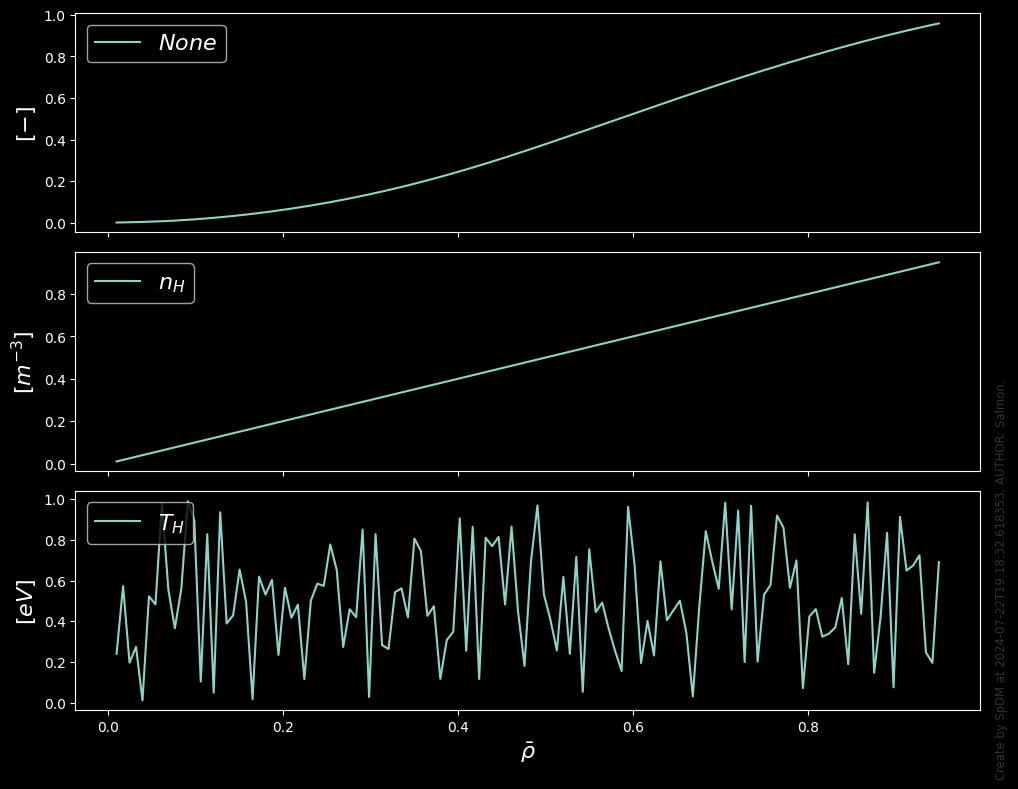

In [8]:
fig = sp_view.plot(
    (core_profiles.profiles_1d.grid.rho_tor_norm, r"$\bar{\rho}$"),
    core_profiles.profiles_1d.grid.psi_norm,
    (core_profiles.profiles_1d.ion["H"].density, r"$n_H$"),
    (core_profiles.profiles_1d.ion["H"].temperature, r"$T_H$"),
)

## 模块调用

In [14]:
class CoreTransportDemo(CoreTransport.Model, code={"name": "demo"}):
    """Plugin Demo: CoreTransportModel"""

    def execute(
        self, *args, equilibrium: Equilibrium, core_profiles: CoreProfiles, **kwargs
    ) -> typing.Self:
        res: CoreTransportDemo = super().execute(
            *args,
            equilibrium=equilibrium,
            core_profiles=core_profiles,
            **kwargs,
        )

        eq_1d = equilibrium.profiles_1d
        prof_1d = core_profiles.profiles_1d
        psi_norm = res.profiles_1d.grid.psi_norm
        rho_tor_norm = res.profiles_1d.grid.rho_tor_norm

        res.profiles_1d.conductivity_parallel = np.sin(rho_tor_norm * 6.28)

        logger.debug(f"CoreTransportDemo: {psi_norm.size}")
        return res

In [15]:
spitzer = CoreTransportDemo()


In [16]:
spitzer.refresh(equilibrium=eq, core_profiles=core_profiles)

2024-07-22 19:19:21,973 [   fytok]    DEBUG: /tmp/ipykernel_4556/3184226436.py:21:execute: CoreTransportDemo: 128


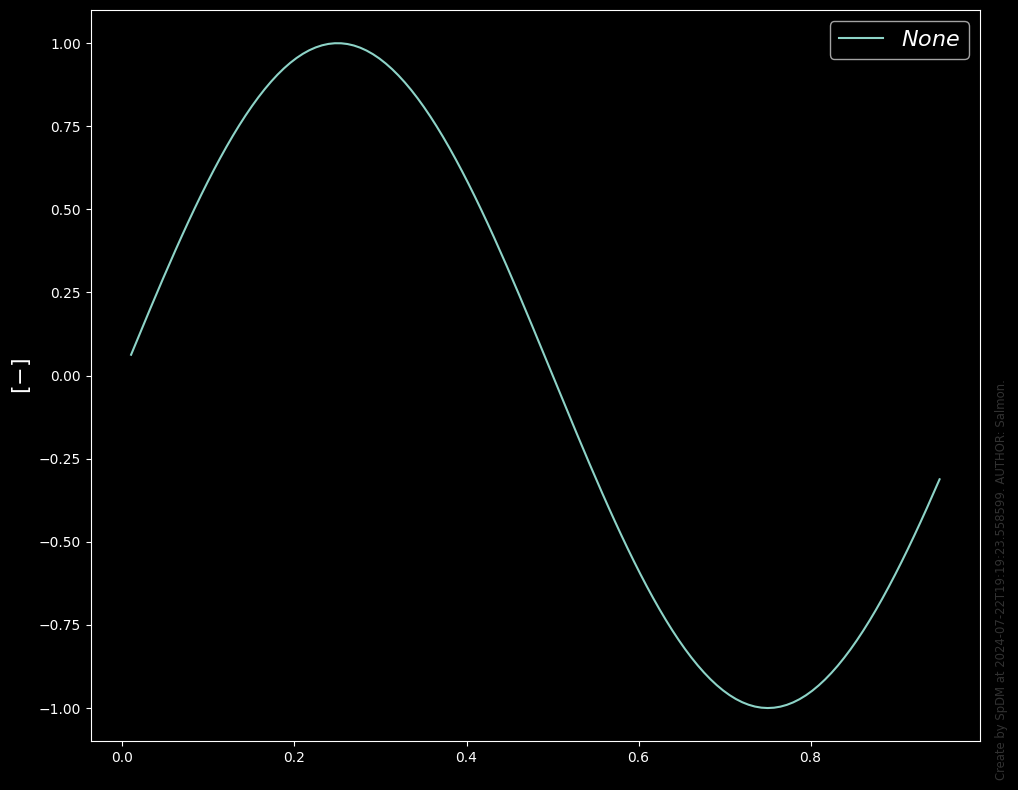

In [17]:
fig=sp_view.plot(spitzer.profiles_1d.grid.rho_tor_norm,spitzer.profiles_1d.conductivity_parallel)

## 插件

In [18]:
model = CoreTransport.Model(code={"name": "demo"})

In [19]:
type(model)

__main__.CoreTransportDemo

In [20]:
model.refresh(equilibrium=eq, core_profiles=core_profiles)

2024-07-22 19:19:31,317 [   fytok]    DEBUG: /tmp/ipykernel_4556/3184226436.py:21:execute: CoreTransportDemo: 128


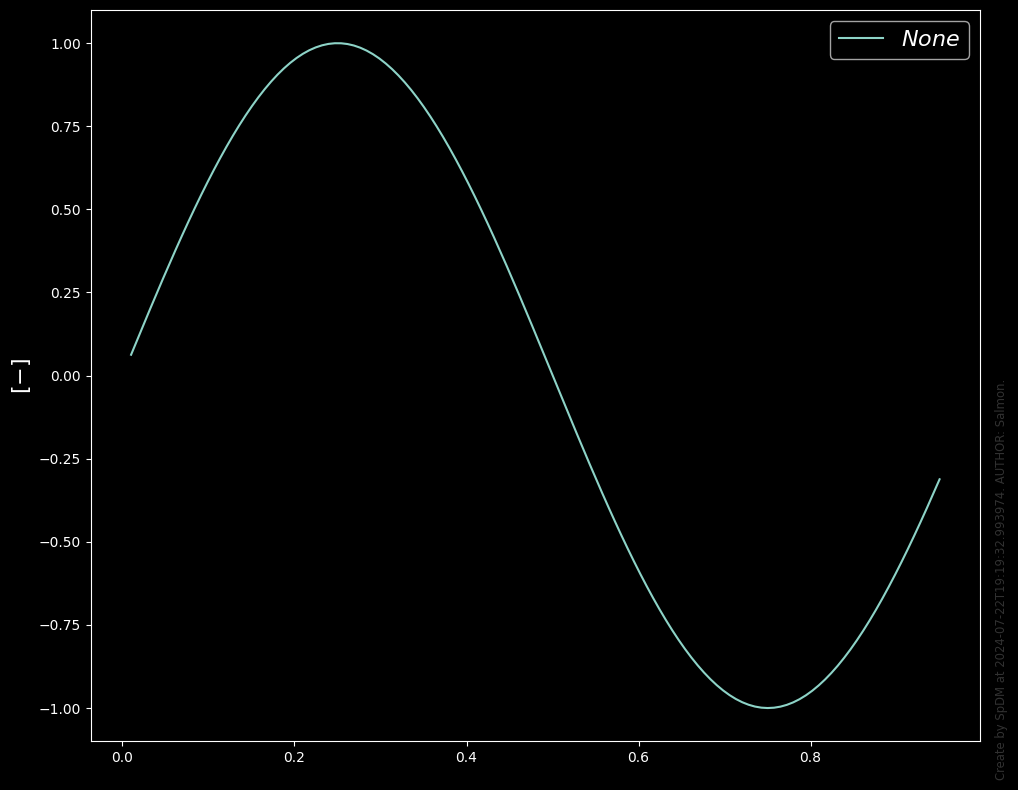

In [21]:
fig=sp_view.plot(model.profiles_1d.grid.rho_tor_norm, model.profiles_1d.conductivity_parallel)